In [1]:
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *
from PreFRBLE.sample import *

In [2]:
scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
    'N_inter' : True
}

scenario_test = {
    'IGM' : ['primordial'],
    'Host': ['JF12/StarDensity_MW'],
    'Local': ['Piro18/wind'], 
}

scenario_test = {
    'IGM' : ['primordial'],
    'Host': ['Heesen11/dirty'],
    'Local': ['Piro18/wind'], 
}


scenario0 = {
    'IGM' : ['primordial'],
    'Host': ['JF12/StarDensity_MW'],
    'Local': ['Piro18/wind'], 
}

scenario_IGM = {
    'IGM' : ['primordial'],
}

f_IGMs = np.arange(0.300,0.901, 0.100)
alphas = np.arange(1.,9.1,1.0)/3


In [25]:
RM = np.abs(FRBs['RM'])
RM = RM[RM>0]
RM.min(), RM.max()

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


(1.5, 220.6)

In [3]:

observed_range = {
    'DM' : (1e1,1e4),
    'RM' : (1e-1,1e3),
    
}
    
    
def LikelihoodObservedMeasure( measure='DM', scenario={}, telescope='Parkes', population='SMD', FRBs=None, Measures=None, use_localized=True, plot=False, plot_FRBs=False, ax=None, label=None, title=None, force=False ):
    """ 
    returns likelihood of values of DM observed by telescope for the case of scenario and population
    
    Parameters
    ----------
    FRBs : array-like
        list of FRBs observed by telescope, result of GetFRBcat( telescopes=[telescope] )
    
    Returns
    -------
    likelihoods : array-like
        1D array with likelihoods of individual DM observed by telescope  
    """
#    print( "measure='{}',".format(measure), "telescope='{}',".format(telescope), "population='{}',".format(population), "force='{}'".format(force), scenario )
    P_M, M = GetLikelihood_Telescope( measure=measure, telescope=telescope, population=population, force=force, **scenario )
#    print(P_M.shape, M.shape, P_M[::49], M[::49])
        
    P_M, M = LikelihoodMeasureable( P=P_M, x=M, min=RM_min )
#    print(P_M[::49], M[::49])
        
    if Measures is None:
        ## read observed values of extragalactic DM
        if FRBs is None:
            FRBs = GetFRBcat( telescopes=[telescope] )
        Measures = GetFRBsMeasures( measure=measure, FRBs=FRBs )
    if plot:
        if ax is None:
            fig, ax = plt.subplots()
        if title is None:
            title = "%s with %s" % (population, telescope)
        ax.set_title( title )
        PlotLikelihood( P=P_M, x=M, measure=measure, label=label, ax=ax )
        
        if plot_FRBs:
            P_, x_ = Histogram( data=np.abs(Measures), bins=10, log=True, density=True, range=observed_range[measure] )#, range=(1e1,1e4) )
            PlotLikelihood( P=P_, x=x_, measure=measure, ax=ax, label="observed", linestyle='-.', color='black' )
#        AllSidesTicks( ax )
    
    ## compute likelihood of observation
    likelihoods = Likelihoods( measurements=Measures, P=P_M, x=M )
    
    ## for FRBs with localized host, use likelihood for DM from that redshift, P(DM|z_host), instead
    if use_localized:
        localized, = np.where( FRBs['host_redshift']>0 )
        for loc in localized:
            z_host = np.round(FRBs[loc]['host_redshift'],1)
            
            P_z, z = GetLikelihood_Redshift( population=population, telescope=telescope )
            P_M, M = GetLikelihood_Full( measure=measure, redshift=z_host, force=force, **scenario )
            
            ## likelihood for host redshift in population 
            prior = Likelihoods( measurements=[z_host], P=P_z, x=z ) ##**( 1 - (telescope in ['ASKAP']) )  ## ignore redhift prior for these telescope, since they are not informative for population
            ## multiply by likelihood for DM at host redshift
            likelihoods[loc], = Likelihoods( measurements=[Measures[loc]], P=P_M, x=M ) * prior 

        if plot_FRBs:
            y_Measures = 0.75-0.5*np.random.rand( len(localized) )
            ax.plot( Measures[localized], y_Measures, marker='x', linestyle=' ' )
    return likelihoods


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


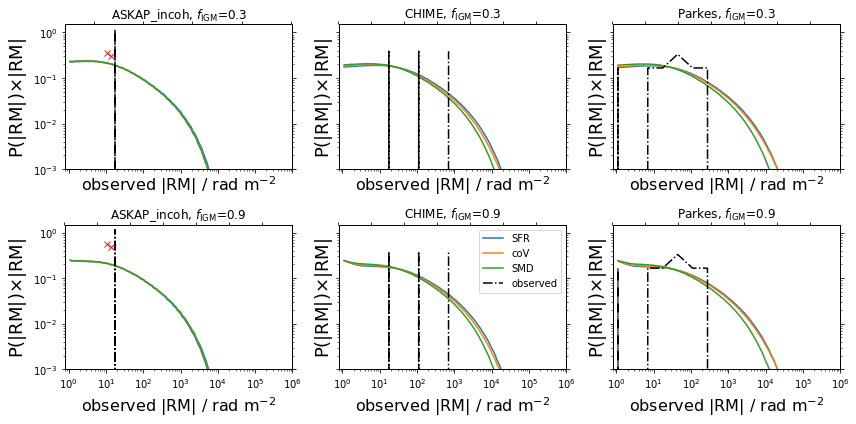

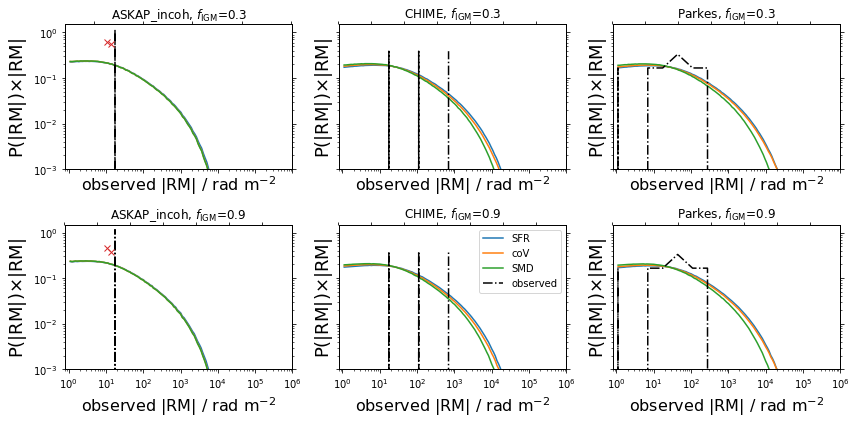

In [17]:
#fig, axss = plt.subplots( 2, 3, figsize=(12,6), sharex=True, sharey=True)
for alpha in [1, 9]:
    fig, axss = plt.subplots( 2, 3, figsize=(12,6), sharex=True, sharey=True)
    for f_IGM, axs in zip( f_IGMs[np.array([0,-1])], axss ):
        tmp = scenario_test.copy()
        tmp['IGM'] = ['alpha%i-3rd_C%.0f' % (alpha, f_IGM*1000)]
#        print(tmp)
        for telescope, ax in zip( telescopes, axs):
#            ax.set_xlim(1e-3,1e3)
            ax.set_ylim(1e-3,1.5)
            #ax.set_ylim(1e-5,1.5)
            ax.set_title( r"%s, $f_{\rm IGM}$=%.1f" % (telescope, f_IGM) )
            for population in populations:
#                P, x = GetLikelihood_Telescope( measure='RM', telescope=telescope, population=population, force=False, **tmp )
#                PlotLikelihood( P=P, x=x,label=population, ax=ax )
                LikelihoodObservedMeasure( force=False, measure='RM', scenario=tmp, telescope=telescope, population=population, plot=True, ax=ax, plot_FRBs=population == populations[-1], label=population, title=r"%s, $f_{\rm IGM}$=%.1f" % (telescope, f_IGM) )
            AllSidesTicks(ax)
    axss[1][1].legend()
    axss[1][1].set_xlim(10.**-0.1,1e6)
    fig.tight_layout()
    plt.show()
#axss[1][1].legend()
#fig.tight_layout()
#plt.show()

{'Local': ['Piro18/wind'], 'IGM': ['alpha1-3rd_C300'], 'Host': ['Rodrigues18']}
{'Local': ['Piro18/wind'], 'IGM': ['alpha1-3rd_C900'], 'Host': ['Rodrigues18']}
{'Local': ['Piro18/wind'], 'IGM': ['alpha9-3rd_C300'], 'Host': ['Rodrigues18']}
{'Local': ['Piro18/wind'], 'IGM': ['alpha9-3rd_C900'], 'Host': ['Rodrigues18']}


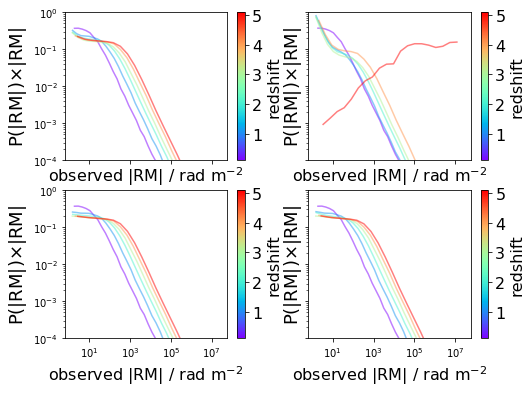

In [91]:
#fig, axss = plt.subplots( len(alphas), len(f_IGMs), figsize=(len(f_IGMs)*4, len(models_IGM[3:])*3), sharex=True, sharey=True )
fig, axss = plt.subplots( 2, 2, figsize=(8,6), sharex=True, sharey=True )
#for i_a, model in enumerate( np.array(models_IGM[3:])[np.array([0,-1])] ):
for i_a, alpha in enumerate( alphas[np.array([0,-1])] ):
    for i_f, f_IGM in enumerate( np.array(f_IGMs)[np.array([0,-1])] ):
        tmp = scenario.copy()
        tmp['IGM'] = ['alpha%i-3rd_C%.0f' % (int(alpha*3), f_IGM*1000)]
        print(tmp)
        ax = axss[i_a][i_f]
        PlotLikelihoodEvolution( measure='RM', measureable=True, ax=ax, scenario=tmp, redshift_bins=redshift_bins[::10] )
        ax.set_ylim(1e-4,1)

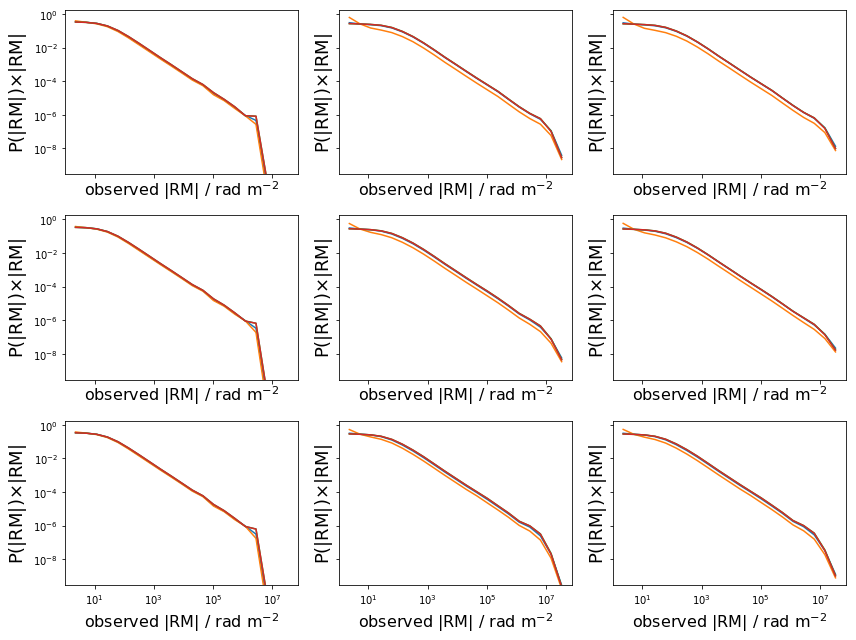

In [18]:

fig, axs = plt.subplots( len(telescopes), len(populations), figsize=(len(populations)*4, 3*len(telescopes)), sharex=True, sharey=True)


for i_t, telescope in enumerate(telescopes):
    for i_p, population in enumerate(populations):
        for i_a, alpha in enumerate( alphas[np.array([0,-1])] ):
            for i_f, f_IGM in enumerate( np.array(f_IGMs)[np.array([0,-1])] ):
                tmp = scenario.copy()
                tmp['IGM'] = ['alpha%i-3rd_C%.0f' % (int(alpha*3), f_IGM*1000)]
                PlotTelescope( measure='RM', measureable=True, telescope=telescope, population=population, ax=axs[i_p][i_t], label=r"$\alpha$ = %.0f/3, $f_{rm IGM}$ = %.1f" % (alpha*3,f_IGM), scenario=tmp, dev=False)
        ax.set_ylim(1e-4,1)
#        ax.legend()
plt.show()

In [13]:
FRBs = GetFRBcat(telescopes=['ASKAP'])
FRBs[FRBs['host_redshift']>0]

array([('FRB181112', 589.27, 102. , 10.9, nan, 0.4755, 'ASKAP'),
       ('FRB180924', 361.42,  40.5, 14. , nan, 0.3214, 'ASKAP')],
      dtype=[('ID', '<U9'), ('DM', '<f4'), ('DM_gal', '<f4'), ('RM', '<f4'), ('tau', '<f4'), ('host_redshift', '<f4'), ('tele', '<U10')])

### Mock sample

perform joint analysis using a mock sample of FRBs

In [34]:
DMs.min(), DMs.max(), RMs.min(), RMs.max()

(64.22276213835735, 144396.72227241, 1.1211579980888635, 3255.476756373073)

In [43]:
N = 500 # number of FRBs

bayes_mock = np.zeros( [ len(populations), len(models_IGM[3:]), len(f_IGMs) ] )
population_ref = 'SMD'
telescope = 'Parkes'

f_IGM = 0.9
alpha = 9./3

scenario_ref = scenario.copy()
scenario_ref['IGM'] = ['alpha{:.0f}-3rd_C{:.0f}'.format(alpha*3 ,f_IGM*1000)]

print( scenario_ref)

FRBs_mock = FakeFRBs( measures=['DM','RM'], N=N, telescope=telescope, population=population_ref, measureable=True, **scenario_ref )
DMs = FRBs_mock['DM']
RMs = FRBs_mock['RM']
zs = FRBs_mock['redshift']

L0 = LikelihoodCombined( DMs=DMs, RMs=RMs, scenario=scenario_ref, telescope=telescope, population=population_ref )
for i_pop, population in enumerate( populations ):
    for i_alpha in trange( len(alphas), desc="alphas for {}".format(population) ):
        alpha = alphas[i_alpha]
#    for i_alpha, alpha in enumerate( alphas ):
#        for i_f in trange( len(f_IGMs), desc='f_IGMs alpha{:.0f}-3rd'.format(alpha*3)):
#            f_IGM = f_IGMs[i_f]
        for i_f, f_IGM in enumerate( f_IGMs ):
            tmp = scenario_ref.copy()
            tmp['IGM'] = [ 'alpha{:.0f}-3rd_C{:.0f}'.format(alpha*3 ,f_IGM*1000) ]
            bayes_mock[i_pop,i_alpha,i_f] = 1 if tmp == scenario_ref and population==population0 else BayesFactorCombined( DMs=DMs, RMs=RMs, scenario1=tmp, scenario2=scenario_ref, L0=L0, population=population, telescope=telescope)[0]
        
    

{'Local': ['Piro18/wind'], 'IGM': ['alpha9-3rd_C900'], 'Host': ['Rodrigues18']}


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:800: RuntimeWarning: invalid value encountered in multiply
  result_dev += add**2 * ( redshift_dev**2 + deviations**2 )
alphas for SMD: 100%|██████████| 9/9 [00:30<00:00,  3.40s/it]


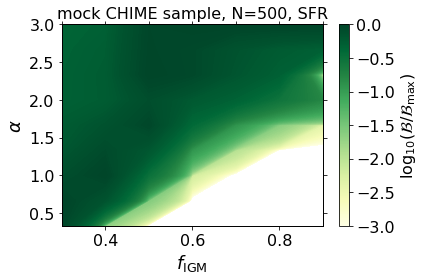

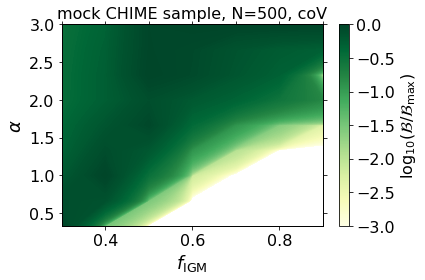

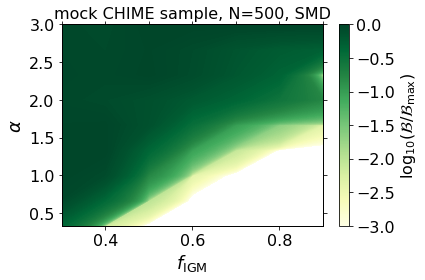

In [67]:
## plot results

#fig, axs = plt.subplots(3,1, figsize=(6,12))
for i_b, b in enumerate( bayes_mock ):
    fig, ax = plt.subplots()
#    ax = axs[i_b]
    ## renormalize every choice of f_IGM to maximum of that f_IGM
    bb = b.copy()
    for i_f in range(len(f_IGMs)):
        bb[:,i_f] /= bb[:,i_f].max()
#    print(np.round(bb/bb.max(),2))
    
    PlotBayes2D( bayes=bb, y=alphas, x=f_IGMs, ylabel=r"$\alpha$", xlabel=r"$f_{\rm IGM}$", ax=ax, plane=True, P_min=1e-3 )
    ax.set_title( 'mock CHIME sample, N=%i, %s' % (N, populations[i_b]), fontsize=16 )
    ax.tick_params(axis='both', which='major', labelsize=16)
    AllSidesTicks(ax)
    fig.tight_layout()
    plt.show()

assuming $f_{\rm IGM} = 0.9$, $\alpha=9/3$ and population=SMD, use mock catalogs of increasing size to see how many FRBs at CHIME are required to derive an upper limit on the IGMF-density-relation $\alpha$ and to determine that upper limit.

In [5]:
f_IGM = 0.9
alpha = 9./3
population = 'SMD'
telescope = 'CHIME'

scenario_test = {
    'IGM' : ['primordial'],
    'Host': ['Heesen11/dirty'],
    'Local': ['Piro18/wind'], 
}

scenario_ref = scenario.copy()
#scenario_ref = scenario_IGM.copy()
scenario_ref['IGM'] = ['alpha{:.0f}-3rd_C{:.0f}'.format(alpha*3 ,f_IGM*1000)]

print( scenario_ref)

N_N = 10

Ns = (10.**np.linspace(1,4,N_N)).astype('i')

tries = 10 # number of repetitions to obtain error on bayes factors

measureable = True # consider that RM < RM_min are not observable?

Bayes = np.zeros( [ len(alphas), len(Ns) ] )
Bayes_std = np.zeros( [ 2, len(alphas), len(Ns) ] )

for i_N, N in enumerate(Ns):
#for i_N in trange(len(Ns )):
#    N = Ns[i_N]
    bayes = np.zeros( [ len( alphas ), tries ] )
    for i in trange(tries, desc='tries for N={}'.format(N)):
#        FRBs_mock = FakeFRBs( measureable=False, measures=['DM','RM'], N=50, telescope=telescope, population=population, **scenario_ref )# **scenario0 )
        FRBs_mock = FakeFRBs( measures=['DM','RM'], N=N, telescope=telescope, population=population, measureable=measureable, **scenario_ref )# **scenario0 )
        DMs = FRBs_mock['DM']
        RMs = FRBs_mock['RM']
        zs = FRBs_mock['redshift']

    
        P0 = LikelihoodCombined( DMs=DMs, RMs=RMs, scenario=scenario_ref, telescope=telescope, population=population, measureable=measureable )
        for i_a, alpha in enumerate( alphas ):
            tmp = scenario_ref.copy()
            tmp['IGM'] = [ 'alpha{:.0f}-3rd_C{:.0f}'.format(alpha*3 ,f_IGM*1000) ]
            
                
#            print(tmp)
#            bayes[i_a,i] = BayesFactorCombined( DMs=DMs, RMs=RMs, scenario1=tmp, scenario2=scenario0, population=population, telescope=telescope)
            bayes[i_a,i] = 1 if tmp == scenario_ref else np.prod( LikelihoodCombined( DMs=DMs, RMs=RMs, scenario=tmp, telescope=telescope, population=population, measureable=measureable ) / P0 )

    Bayes[:,i_N], Bayes_std[:,:,i_N] = LogMeanStd( bayes, axis=1 )

tries for N=10:   0%|          | 0/10 [00:00<?, ?it/s]

{'IGM': ['alpha9-3rd_C900'], 'Inter': ['Rodrigues18'], 'Host': ['Rodrigues18'], 'Local': ['Piro18/wind'], 'N_inter': True}


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:227: RuntimeWarning: invalid value encountered in double_scalars
  dev[ib] += add**2 * ( np.sum( ( devs[i_f][ix]*f[ix]*np.diff(x_) )**2 ) /np.sum( ( f[ix]*np.diff(x_) )**2 )  + dev_weights[i_f]**2 )
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:866: RuntimeWarning: invalid value encountered in multiply
  result_dev += add**2 * ( redshift_dev**2 + deviations**2 )
tries for N=10000: 100%|██████████| 10/10 [04:54<00:00, 29.47s/it]


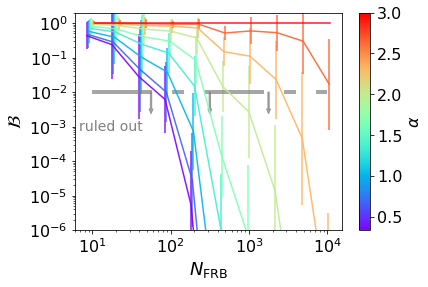

In [14]:
## plot results

fig, ax = plt.subplots()
plt.loglog()
for i_a, color in enumerate( Rainbow(alphas) ):
#    if i_a == 6:
#        continue
    plt.errorbar( Ns*(1-0.15+0.03*i_a), Bayes[i_a], yerr=Bayes_std[:,i_a], color=color, alpha=0.9 )
    alpha = alphas[i_a]

    
#for x, y, alpha in zip( [2e1, 2e2, 1e3, 5e3], [1e-6,1e-6,1e-6,1e-6],  alphas[alphas<5./3] ):
#    plt.text( x, y, r"$\alpha=\frac{{{:.0f}}}{{3}}$".format(alpha*3), fontsize=16)    
#plt.text( 3e3, 1e-1, r"$\alpha \geq \frac{{5}}{{3}}$", fontsize=16)    

Colorbar( alphas, label=r"$\alpha$" )
plt.xlabel( r"$N_{\rm FRB}$", fontdict={'size':18 } )
plt.ylabel( r"$\mathcal{B}$", fontdict={'size':18 } )
plt.ylim(1e-6,2)
PlotLimit(ax=ax, x=[Ns[0],Ns[-1]], y=[1e-2,1e-2], lower_limit=False, label='ruled out', arrow_number=3, shift_text_vertical=-9e-3, shift_text_horizontal=-2.99e2)
ax.tick_params(axis='both', which='major', labelsize=16)
AllSidesTicks(ax)
plt.show()

perform joint analysis using events in FRBcat

In [57]:
bayes = np.zeros( [ len(populations), len(telescopes), len(models_IGM[3:]), len(f_IGMs) ] )

for i_p, population in enumerate( populations ):
#for i_p in trange( len(populations) ):
#    population = populations[i_p]
#    for i_t, telescope in enumerate( telescopes ):
    for i_t in trange(len(telescopes), desc="telescopes for population {}".format(population)):
        telescope = telescopes[i_t]
        FRBs = GetFRBcat( telescopes=[telescope] )
        DMs = GetFRBsMeasures( measure='DM', FRBs=FRBs)
        RMs = GetFRBsMeasures( measure='RM', FRBs=FRBs)
        L0 = LikelihoodCombined( DMs=DMs, RMs=RMs, scenario=scenario, telescope=telescope, population=population )
        for i_a, model in enumerate( models_IGM[3:] ):
            for i_f, f_IGM in enumerate( f_IGMs ):
                tmp = scenario_test.copy()
                tmp['IGM'] = [ "%s_C%.0f" % ( model, f_IGM*1000 ) ]
#                print(tmp)
                bayes[i_p,i_t,i_a,i_f] = BayesFactorCombined( DMs=DMs, RMs=RMs, scenario1=tmp, scenario2=scenario, population=population, telescope=telescope)[0]
        
    



telescopes for population SFR:   0%|          | 0/3 [00:00<?, ?it/s]/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:34: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:293: RuntimeWarning: divide by zero encountered in true_divide
  
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:293: RuntimeWarning: invalid value encountered in true_divide
  
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:290: RuntimeWarning: invalid value encountered in multiply
  ## work with probability, not pdf


ValueError: setting an array element with a sequence.

In [52]:
bayes = 10**( -2-5*np.random.rand(  len(populations), len(telescopes), len(alphas), len(f_IGMs)  ) )

#bayes[:,:,3:5,3:5] *= 1000
telescopes

bayes[:,1] = bayes_mock


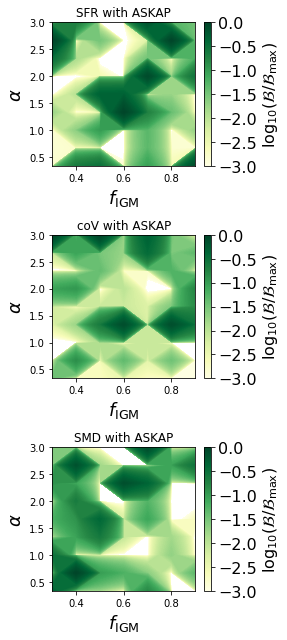

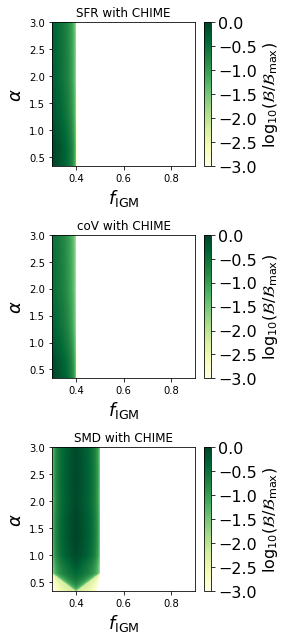

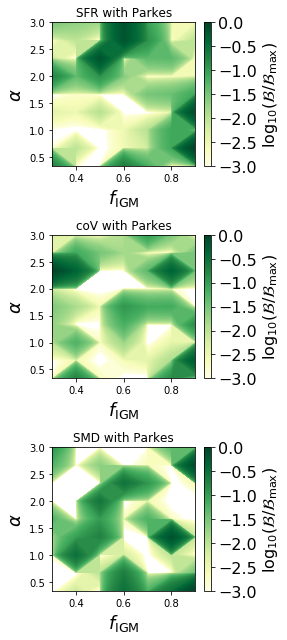

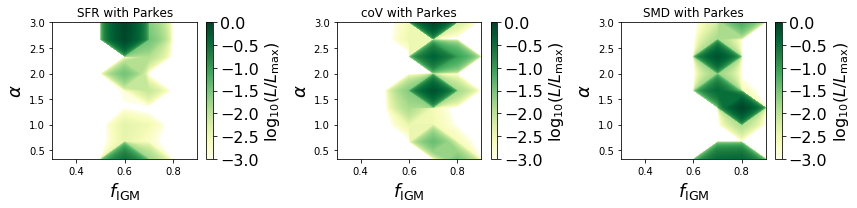

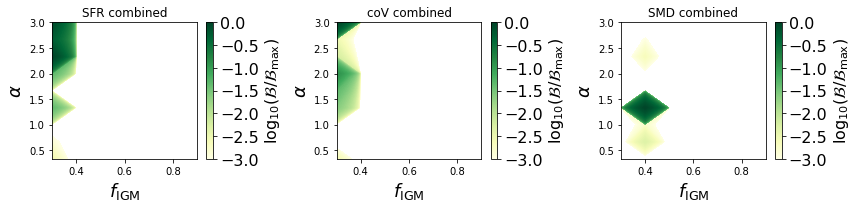

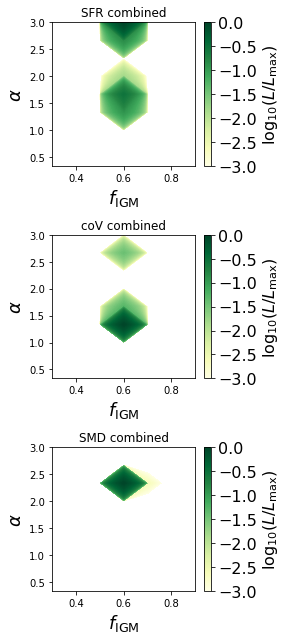

In [53]:
#fig, axss = plt.subplots( len(populations), len(telescopes), figsize=(4*len(populations), 3*(1+len(telescopes)) ) )
#for i_t, (telescope, axs) in enumerate( zip( telescopes, axss) ):
for i_t, telescope in enumerate( telescopes ):
#    fig, axs = plt.subplots( 1, len(populations), figsize=(4*len(populations),3 ) )
    fig, axs = plt.subplots( len(populations), 1, figsize=(4, len(populations)*3 ) )
    for i_p, (population, ax) in enumerate( zip(populations, axs) ):
        PlotBayes2D( P_min=1e-3, bayes=bayes[i_p,i_t], y=alphas, x=f_IGMs, ylabel=r"$\alpha$", xlabel=r"$f_{\rm IGM}$", ax=ax, plane=True )
        ax.set_title( '%s with %s' % (population, labels[telescope]))
    fig.tight_layout()

posterior_fIGM = np.genfromtxt("posterior_fIGM.npy").reshape(len(populations),len(f_IGMs))
prior_alpha = np.ones( len( alphas ) )

## posterior only for Parkes
posterior = bayes[:,-1] * prior_alpha.reshape([1,len(alphas),1]) * posterior_fIGM.reshape( [len(populations),1,len(f_IGMs)] )  

fig, axs = plt.subplots( 1, len(populations), figsize=(4*len(populations), 3 ) )
for i_p, (population, ax) in enumerate( zip(populations, axs) ):
    PlotBayes2D( P_min=1e-3, bayes=posterior[i_p], y=alphas, x=f_IGMs, ylabel=r"$\alpha$", xlabel=r"$f_{\rm IGM}$", ax=ax, plane=True, posterior=True )
    ax.set_title( '%s with Parkes' % population)
fig.tight_layout()




B = np.prod( bayes, axis=1 )
fig, axs = plt.subplots( 1, len(populations), figsize=(4*len(populations), 3 ) )
for i_p, (population, ax) in enumerate( zip(populations, axs) ):
    PlotBayes2D( P_min=1e-3, bayes=B[i_p], y=alphas, x=f_IGMs, ylabel=r"$\alpha$", xlabel=r"$f_{\rm IGM}$", ax=ax, plane=True )
    ax.set_title( '%s combined' % population)
fig.tight_layout()

posterior = B * prior_alpha.reshape([1,len(alphas),1]) * posterior_fIGM.reshape( [len(populations),1,len(f_IGMs)] )  

#fig, axs = plt.subplots( 1, len(populations), figsize=(4*len(populations), 3 ) )
fig, axs = plt.subplots( len(populations), 1, figsize=(4, len(populations)*3 ) )
for i_p, (population, ax) in enumerate( zip(populations, axs) ):
    PlotBayes2D( P_min=1e-3, bayes=posterior[i_p], y=alphas, x=f_IGMs, ylabel=r"$\alpha$", xlabel=r"$f_{\rm IGM}$", ax=ax, plane=True, posterior=True )
    ax.set_title( '%s combined' % population)
fig.tight_layout()




In [22]:
FRBs = GetFRBcat( telescopes=telescopes)

In [32]:
FRBs[np.abs(FRBs['RM'])>0]

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([('FRB181112',  589.27, 102. ,   10.9,  nan, 0.4755, 'ASKAP'),
       ('FRB180924',  361.42,  40.5,   14. ,  nan, 0.3214, 'ASKAP'),
       ('FRB180916',  349.2 , 200. , -114.6,  nan,    nan, 'CHIME/FRB'),
       ('FRB180714', 1467.92, 257. ,  -25.9,  nan,    nan, 'parkes'),
       ('FRB180311', 1570.9 ,  45.2,    4.8,  nan,    nan, 'parkes'),
       ('FRB171209', 1457.4 ,  13. ,  121.6, 0.66,    nan, 'parkes'),
       ('FRB160102', 2596.1 ,  13. , -220.6, 4.  ,    nan, 'parkes'),
       ('FRB150807',  266.5 ,  36.9,   12. ,  nan,    nan, 'parkes'),
       ('FRB150418',  776.2 , 188.5,   36. ,  nan,    nan, 'parkes'),
       ('FRB150215', 1105.6 , 427.2,    1.5,  nan,    nan, 'parkes')],
      dtype=[('ID', '<U9'), ('DM', '<f4'), ('DM_gal', '<f4'), ('RM', '<f4'), ('tau', '<f4'), ('host_redshift', '<f4'), ('tele', '<U10')])